## Experiment 2 - Alternate Approach
- Seeing which algorithm **converges faster to cost ~ = 1**, given a particular unitary size and given number of max iterations 
- Iterations ranged from [5,20] with a change of 2 in between 
- Resolution is 30 and error threshold is $10^{-3}$

In [1]:
iterations = [i for i in range(5, 20, 2)]
iterations

[5, 7, 9, 11, 13, 15, 17, 19]

### Metrics Plotted
- The cost returned by the algorithm is plotted in each case 
- Along with cost, the average error from the **closest eigenvalue** is calculated.
- Note that each trial with ,say, $MAX$ iterations is executed 5 times to get a good estimate of the result. 

### Imports

In [2]:
from qiskit import IBMQ
import random 
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

# IBMQ.load_account()

# provider = IBMQ.get_provider(hub='ibm-q-education')
# santiago = provider.get_backend('ibmq_santiago')
# casablanca = provider.get_backend('ibmq_casablanca')
# bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')
# athens = provider.get_backend('ibmq_athens')

In [3]:
from normal_SPEA import SPEA
from changed_SPEA import global_max_SPEA

### Plotter function

In [4]:
def generate_plots(unitary_size, costs, errors, overlaps, algorithm):

    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3 = random.sample(colors, 3)

    # plot
    os.makedirs("Experiment_2/"+str(unitary_size) +
                "_qubit(random)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost v/s Max iters", fontsize=16)
    ax1.set_xlabel("Maximum iterations ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    ax1.plot(iterations, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(iterations, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % error v/s Max iters", fontsize=16)
    ax2.set_xlabel("Maximum iterations ", fontsize=15)
    ax2.set_ylabel("% error for nearest eigenvalue", fontsize=15)
    ax2.plot(iterations, errors, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_2/"+str(unitary_size)+"_qubit(random)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

### Result Generator

In [5]:
def get_results(eig_vals, eig_vect, basis, basis_ind, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_g = []
    max_overlaps_g = []
    # find how the cost converges with increasing iterations
    for iters in iterations:
        costs = []
        errors = []
        overlaps = []
        
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=30, error=3, max_iters=iters)
            else:
                spea = global_max_SPEA(
                    unitary, resolution=30, error=3, max_iters=iters)

            result = spea.get_eigen_pair(
                progress=False, backend=sim, basis=basis, basis_ind=basis_ind,
                algo='alternate', randomize=False,shots = 2**12)

            if result['cost'] < 0.65:
                continue
                        
            # find the costs
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors.append(perc_error)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)

        print("Result with", iters, " iterations :")
        print("AVG. COST :", np.average(costs),
              "AVG. ERROR :", np.average(errors))
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_g.append(np.average(errors))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_g, max_overlaps_g

## 2 - qubit unitary


In [62]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[ 0.27044227+0.59260122j,  0.19815327+0.16718258j,
        -0.07380667+0.14661041j,  0.43113801-0.54373525j],
       [-0.27599783+0.50619721j, -0.27051526+0.07035176j,
         0.60387709+0.17365941j, -0.43881077-0.04562546j],
       [ 0.0363661 -0.13428246j, -0.05718308-0.58085295j,
         0.5859525 -0.22338873j,  0.49048112-0.07855622j],
       [-0.43519246+0.18581605j,  0.67226263-0.24911904j,
        -0.08898788-0.4207982j , -0.24094564-0.13797756j]])

- Generating eigenvalues to benchmark against


In [63]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 8.72711896e-01+0.j          2.83402388e-01+0.06917941j
   1.55618170e-01+0.35509612j -5.18890160e-02-0.01638603j]
 [ 4.92263159e-03+0.21188235j  6.92264912e-01+0.j
   1.08758603e-01-0.56196274j  2.52377654e-01+0.29073338j]
 [ 4.65791213e-02-0.17463957j -1.89672235e-01+0.37774072j
  -8.04020948e-03+0.09584098j  8.82846338e-01+0.j        ]
 [-2.27740801e-04+0.40098247j -2.53713128e-01-0.43889934j
   7.16106864e-01+0.j          2.19136071e-01-0.14622029j]]
Eigenvalues : [0.16554601 0.34506238 0.67325411 0.91633862]


### Generate the Basis Set

In [64]:
sample = unitary_group.rvs(4)
basis2 = []
for k in sample:
    basis2.append(np.array(k, dtype=complex))
ind = np.random.choice(range(4))
#     print(ind)
basis_indices2 = ind 
# print("Basis set :",bases2)
print("Basis indices :",basis_indices2)

Basis indices : 1


#### Algorithm 1

In [65]:
costs_2qubit_b, errors_2qubit_b, max_overlaps_2qubit_b = get_results(eig_vals2,
                                                                     eig_vect2, basis2, basis_indices2,
                                                                     unit_2, "original", 3)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.8933919270833334 AVG. ERROR : 11.54734321012235
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.9044596354166666 AVG. ERROR : 10.219289140443427
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 9  iterations :
AVG. COST : 0.962890625 AVG. ERROR : 5.061725045599458
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iteratio

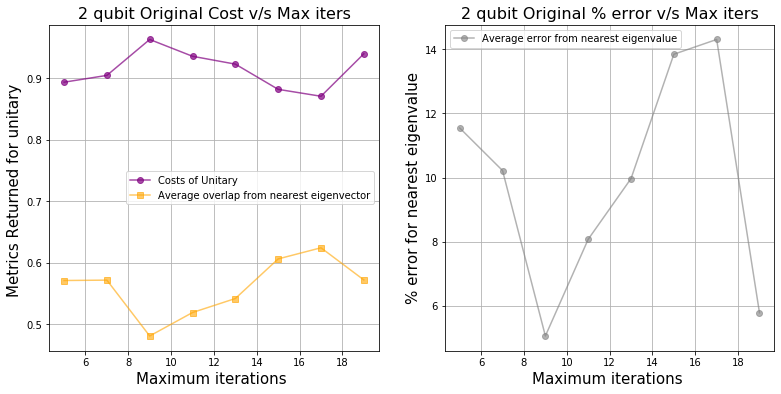

In [66]:
generate_plots(2, costs_2qubit_b, errors_2qubit_b,
               max_overlaps_2qubit_b, "Original")

#### Algorithm 2

In [68]:
costs_2qubit_c, errors_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, basis2, basis_indices2, unit_2, "modified", 3)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.86181640625 AVG. ERROR : 15.09801937217299
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.8777669270833334 AVG. ERROR : 12.72384963791062
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 9  iterations :
AVG. COST : 0.8802897135416666 AVG. ERROR : 13.682520703360657
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterat

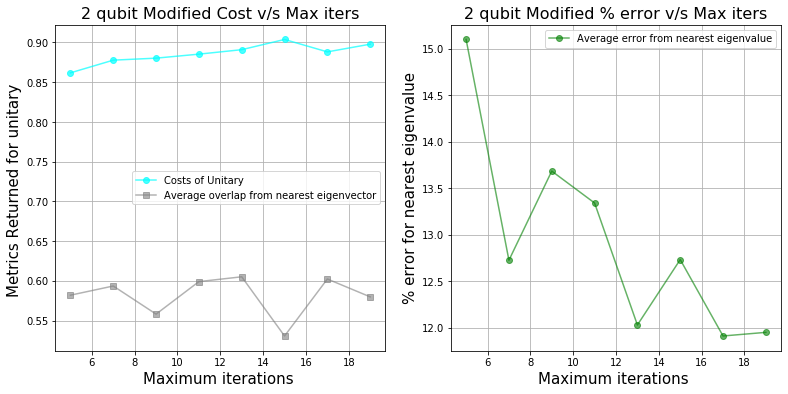

In [69]:
generate_plots(2, costs_2qubit_c, errors_2qubit_c,
               max_overlaps_2qubit_c, "Modified")

## 3 - qubit unitary

In [70]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[ 3.73714217e-01+0.13783967j, -3.23732773e-01-0.22204289j,
        -1.88011131e-01+0.21036046j, -8.40100305e-04-0.20647407j,
        -3.40948031e-01+0.34673747j,  4.79666408e-01+0.18151938j,
         1.72459874e-01+0.08160721j,  1.65735661e-01+0.04034803j],
       [-4.88227494e-03-0.17815091j,  8.60272848e-02-0.23488334j,
         2.09040198e-01+0.13273555j, -4.88098929e-01+0.26998136j,
        -4.45782105e-02+0.41805168j, -1.83500292e-01+0.28347789j,
        -2.28128962e-01+0.33255891j, -2.73868503e-01+0.06922289j],
       [ 3.96105136e-01-0.06925153j, -3.71065393e-02+0.13011655j,
         3.37618907e-01-0.38792356j, -1.06049680e-01-0.05520983j,
        -6.95892387e-02+0.06188267j, -4.09781373e-01+0.25946542j,
         2.41080800e-01-0.06798034j,  4.84328952e-01-0.00091491j],
       [-2.48568666e-01+0.18519595j, -3.01300501e-01-0.13556511j,
        -2.74274262e-01-0.09642004j,  1.78505536e-01+0.23593933j,
        -8.95610103e-02+0.37036276j, -3.50651974e-01-0.28324441j,
       

In [71]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[-2.83758931e-01+0.18477651j -1.14842986e-01-0.08007114j
   1.11812323e-01-0.35020374j  5.92535274e-01+0.j
   7.77620869e-02+0.43401924j  1.09002552e-02-0.3092231j
  -1.57096614e-01-0.18184728j  2.17334419e-02-0.17640296j]
 [-3.40862980e-02+0.28812867j -1.28190752e-01+0.22663476j
   1.66914564e-01+0.30548957j -1.62483064e-01-0.3400024j
  -2.76616574e-01+0.13970943j  2.57364482e-02-0.15446633j
  -1.68212664e-01+0.01557683j  6.60107018e-01+0.j        ]
 [-2.11337673e-01-0.078836j    2.14086616e-01+0.23681107j
  -1.89278187e-01+0.02499505j  1.30217668e-01-0.30916404j
  -6.10812695e-02+0.24366333j  5.61252675e-03+0.16307591j
   7.70034849e-01+0.j          4.98729022e-02-0.11423535j]
 [-2.83711682e-01+0.35037882j -1.54709068e-01+0.40381207j
  -2.84181724e-02+0.16164534j -4.25522527e-02+0.52583151j
   4.50104020e-01+0.j         -2.00375090e-01+0.11012784j
   1.13351541e-01+0.00530475j  1.07431311e-01+0.15876669j]
 [-3.60526118e-01+0.02370571j -8.37427299e-02+0.40727604j
   1.8

### Generate Basis Set

In [72]:
sample = unitary_group.rvs(8)
basis3 = []
for k in sample:
    basis3.append(np.array(k, dtype=complex))
ind = np.random.choice(range(8))
print("Basis index :",ind)
basis_indices3 = ind

Basis index : 7


### Algorithm 1

In [73]:
costs_3qubit_b, errors_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3,basis3, basis_indices3, unit_3, "original", 3)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.91162109375 AVG. ERROR : 3.5822445341779066
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.9105631510416666 AVG. ERROR : 13.08990199380496
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 9  iterations :
AVG. COST : 0.9156087239583334 AVG. ERROR : 3.153649002732713
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterat

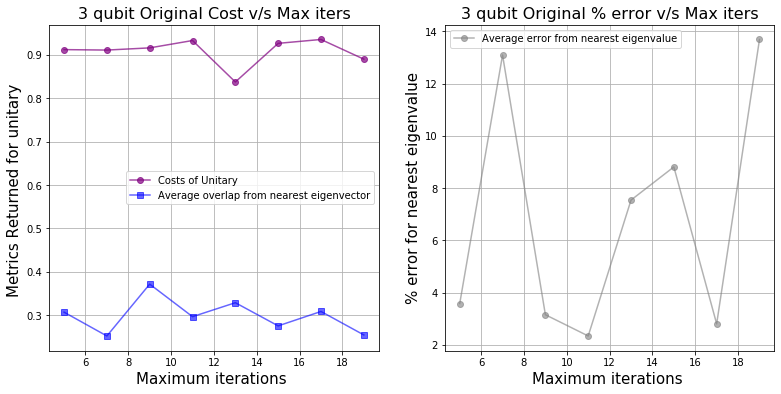

In [74]:
generate_plots(3, costs_3qubit_b, errors_3qubit_b,
               max_overlaps_3qubit_b, "Original")

### Algorithm 2

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.93878173828125 AVG. ERROR : 1.670613746381693
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
T

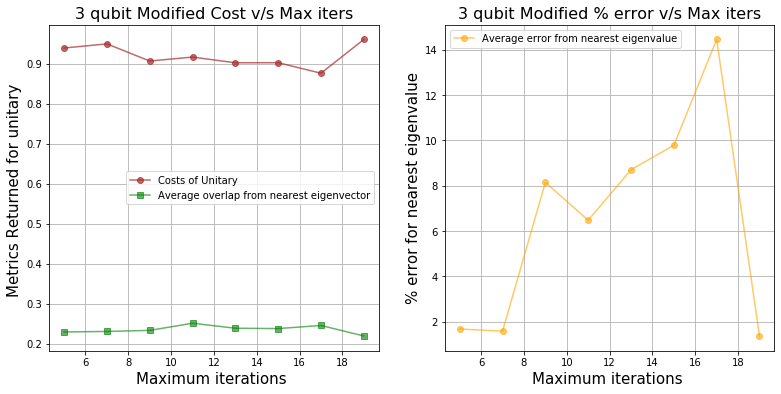

In [75]:
costs_3qubit_c, errors_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, basis3, basis_indices3, unit_3, "modified", 4)
generate_plots(3, costs_3qubit_c, errors_3qubit_c,
               max_overlaps_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

In [ ]:
eig_vals4, eig_vect4 = np.linalg.eig(unit_4)
eig_vals4 = np.angle(eig_vals4)
e = []
for k in eig_vals4:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals4 = np.array(e)
print("Eigenstates :", eig_vect4)
print("Eigenvalues :", eig_vals4)

### Generating basis set


In [ ]:
bases4 , basis_indices4 = [], []
for _ in range(4):
    sample = unitary_group.rvs(16)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(16))
    bases4.append(basis)
    basis_indices4.append(ind)
print("Basis indices :",basis_indices4)

- Algorithm 1

In [ ]:
costs_4qubit_b, errors_eig_4qubit_b, max_overlaps_4qubit_b = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'original', 4)
generate_plots(4, costs_4qubit_b, 
               errors_eig_4qubit_b, max_overlaps_4qubit_b, "Original")

- Algorithm 2

In [ ]:
costs_4qubit_c, errors_eig_4qubit_c,  max_overlaps_4qubit_c = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'modified', 4)
generate_plots(4, costs_4qubit_c, 
               errors_eig_4qubit_c, max_overlaps_4qubit_c, "Modified")